In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

%matplotlib inline
from keras.utils import np_utils

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


number sentences : 122014


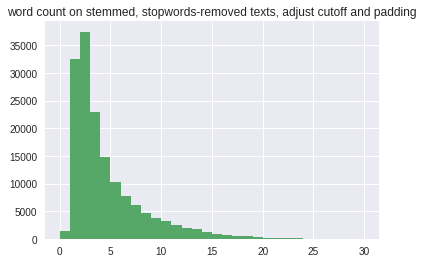

In [2]:
#preprocess
from nltk import word_tokenize          
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

class TimoTokenizer(object):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.remove('but')
        self.stop_words.remove('not') # left outer join would be nice...
        self.tokenizer = RegexpTokenizer('[a-z]\w+')
    def lmtokenize(self,doc):
        temp = self.tokenizer.tokenize(doc.lower())
        stopwordsremoved = np.asarray([t for t in temp if t not in self.stop_words])
        return stopwordsremoved
    
def removeSubsentence(df):
    #laggles rotten competition has many (useless?) subsentences,
    # they should all occur at first index of senenceId, hence nonzero[0][0]
    sent_id = df['SentenceId'].values
    unique_sent_id = np.unique(sent_id)
    myidx = np.zeros(unique_sent_id.shape[0],dtype="int")
    for i,val in enumerate(unique_sent_id):
        myidx[i] = int(np.nonzero(sent_id == val)[0][0])
    return df.iloc[myidx]
    

def preprocess(df,num_words):
    #remove non characters and aply stemming
    phrases = df["Phrase"].values
    sentiments = df["Sentiment"].values
    tokenizer=TimoTokenizer()
    sentences = np.asarray([tokenizer.lmtokenize(text) for text in phrases])
    lengths = np.asarray([len(text) for text in sentences]) #double computation
    #histplot of lengths for cutoff selection
    plt.hist(lengths,np.max(lengths))
    plt.title("word count on stemmed, stopwords-removed texts, adjust cutoff and padding")
    idx = np.nonzero(lengths > num_words)[0]
    sentiments = sentiments[idx]
    sentences = sentences[idx]
    return sentences,sentiments

def preprocessTest(df):
    #remove non characters and aply stemming
    phrases = df["Phrase"].values
    tokenizer=TimoTokenizer()
    sentences = np.asarray([tokenizer.lmtokenize(text) for text in phrases])
    return sentences

def embedSentence(sentences,embeddings_index,nb_timesteps =25,d_embedding = 100):   
    X = np.zeros((len(sentences),nb_timesteps,d_embedding))
    # manual zero padding and truncation
    for i,doc in enumerate(sentences):
        all_vectors = []
        for word in doc:
            temp = embeddings_index.get(word)
            if temp is not None:
                all_vectors.append(temp)

        start = np.max([nb_timesteps - len(all_vectors),0])
        finish = np.min([nb_timesteps, len(all_vectors)])
        X[i,start:,:] = np.reshape(np.asarray(all_vectors[:finish]),(1,nb_timesteps-start,d_embedding))
    return X


num_words = 1
train_df = pd.read_csv('rotten/train.tsv', sep='\t', header=0)
test_df = pd.read_csv('rotten/test.tsv', sep='\t', header=0)
#train_df = removeSubsentence(train_df)
sentences,sentiments = preprocess(train_df,num_words)
test_sentences = preprocessTest(test_df)
sentences,sentiments = preprocess(train_df,num_words)
print("number sentences : %i" %(len(sentences)))    

In [3]:
#load glove vectors
embeddings_index = {}
GLOVE_DIR = 'rotten/glove.6B'
import os
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [5]:
X = embedSentence(sentences,embeddings_index,nb_timesteps = 20,d_embedding = 100)
test_X = embedSentence(test_sentences,embeddings_index,nb_timesteps = 20,d_embedding = 100)
y = np_utils.to_categorical(sentiments)
print(X.shape)
print(test_X.shape)
print(y.shape)

(122014, 20, 100)
(66292, 20, 100)
(122014, 5)


In [6]:
#LSTM
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Embedding, BatchNormalization
from keras.layers import LSTM, GRU, AveragePooling1D

inp = Input(shape=X.shape[1:])

#x = Embedding(input_dim=len(train_vocab),output_dim=128,input_length=inputlength,input_shape=(1,))(inp)
x = LSTM(400, return_sequences=False, dropout_W = 0.3, dropout_U = 0.3, input_shape=X.shape[1:] )(inp)
x = Dropout(0.3)(x)
pred = Dense(5,activation='softmax')(x)

model = Model(inp,pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 20, 100)       0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 400)           801600      input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 400)           0           lstm_1[0][0]                     
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 5)             2005        dropout_1[0][0]                  
Total params: 803,605
Trainable params: 803,605
Non-trainable params: 0
___________________

In [19]:
# model results on test set: 
# LSTM(400,dr_W = 0.3, dr_U = 0.3) + Dr(0.3) + Dense(5) -> 1 epoch 0.604, 15 epochs 0.636

idx = np.random.permutation(X.shape[0])
model.fit(X[idx], y[idx], nb_epoch=8, batch_size=64, verbose=1)#,validation_split=0.2)

Epoch 1/14
122014/122014 [==============================] - 74s - loss: 1.0470 - categorical_accuracy: 0.5595    
Epoch 2/14
122014/122014 [==============================] - 72s - loss: 1.0031 - categorical_accuracy: 0.5769    
Epoch 3/14
122014/122014 [==============================] - 74s - loss: 0.9673 - categorical_accuracy: 0.5906    
Epoch 4/14
122014/122014 [==============================] - 73s - loss: 0.9386 - categorical_accuracy: 0.6056    
Epoch 5/14
122014/122014 [==============================] - 72s - loss: 0.9139 - categorical_accuracy: 0.6144    
Epoch 6/14
122014/122014 [==============================] - 74s - loss: 0.8923 - categorical_accuracy: 0.6236    
Epoch 7/14
122014/122014 [==============================] - 74s - loss: 0.8768 - categorical_accuracy: 0.6300    
Epoch 8/14
122014/122014 [==============================] - 76s - loss: 0.8650 - categorical_accuracy: 0.6351    
Epoch 9/14
122014/122014 [==============================] - 75s - loss: 0.8546 - categor

In [20]:
predictions = model.predict(test_X,batch_size=64)
preds = np.argmax(predictions,axis=1)
test_df["Sentiment"] = pd.Series(preds,index=test_df.index)
header = ["PhraseId", "Sentiment"]
test_df.to_csv('rotten/predictions.csv', columns = header,index=False)